In [23]:
import numpy as np


def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


def dsigmoid(Z):
    A = sigmoid(Z)
    return A * (1 - A)


def relu(Z):
    return np.maximum(0, Z)


def drelu(Z):
    return np.heaviside(Z, 0)
    

def compute_cost(Yh, Y, parameters, lambd=0):
    """
    Yh -- prediction vector of size(1, number of examples)
    Y -- label vector of size(1, number of examples)
    """
    m = Y.shape[1]
    L = len(parameters) // 2
    l2_regularization_cost = 0
    for l in range(L):
        l2_regularization_cost += np.sum(np.square(parameters['W' + str(l+1)]))
    
    l2_regularization_cost = l2_regularization_cost * lambd / (2 * m)
    
    return (np.dot(Y, np.log(Yh).T) + np.dot((1 - Y), np.log(1 - Yh).T))/-m + l2_regularization_cost


def compute_dcost(Yh, Y):
    return -np.divide(Y, Yh) + np.divide(1 - Y, 1 - Yh)
    

def initialize_parameters(layer_dims):
    parameters = {}
    
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters


def step_forward(W, b, Ap, activate):
    Z = np.dot(W, Ap) + b
    return Z, activate(Z)
    

def linear_forward_propagation(parameters, X, activation): 
    A = X
    m = X.shape[1]
    
    caches = []
    L = len(parameters) // 2 + 1
    
    for l in range(1, L):       
        Ap = A
        Z, A = step_forward(parameters['W' + str(l)], parameters['b' + str(l)], Ap, sigmoid if l == L - 1 else activation)
        caches.append((Z, Ap, parameters['W' + str(l)], parameters['b' + str(l)]))
    
    return A, caches


def step_backward(cache, dA, dactivation, lambd=0):
    Z, Ap, W, b = cache
    m = Z.shape[1]
    
    dZ = dA * dactivation(Z)
    dW = np.dot(dZ, Ap.T)/m + lambd/m * W
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dAp = np.dot(W.T, dZ) 
    
    return dAp, dW, db

    
def linear_backward_propagation(caches, Yh, Y, dactivation, lambd=0):    
    L = len(caches)
    grads = {}
    
    current_cache = caches[L-1]
    dAL = compute_dcost(Yh, Y)
    grads['dA' + str(L)] = dAL
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = step_backward(current_cache, dAL, dsigmoid, lambd)
    
    dA = grads['dA' + str(L-1)]
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dA' + str(l)], grads['dW' + str(l+1)], grads['db' + str(l+1)] = step_backward(current_cache, dA, dactivation, lambd) 
        dA = grads['dA' + str(l)]
        
    return grads


def predict(X, y, parameters, activation):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = linear_forward_propagation(parameters, X, activation)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p


def nn_model(X, Y, layer_dims, lambd=0, learning_rate=0.3, loop=30000, print_th_iter=10000):
    """
    X -- data of size (n, number of examples)
    Y -- true "label" vector of size (1, number of examples)
    layer_dims -- the number of nodes in layers including X
    """
    parameters = initialize_parameters(layer_dims)
    for i in range(loop):        
        Yh, caches = linear_forward_propagation(parameters, X, relu)
        grads = linear_backward_propagation(caches, Yh, Y, drelu, lambd)
        
        for l in range(1, len(layer_dims)):
            parameters['W' + str(l)] = parameters['W' + str(l)] - grads['dW' + str(l)] * learning_rate
            parameters['b' + str(l)] = parameters['b' + str(l)] - grads['db' + str(l)] * learning_rate
        
        cost = compute_cost(Yh, Y, parameters, lambd)
        if (i % print_th_iter == 0):
            print("Cost after iteration {}: {}".format(i, cost))            

    return parameters, cost


def _to_theta_vector(dic, layers, wparam, bparam):
    L = layers    
    keys = []
    theta = None
    layer_dims = [dic[wparam + '1'].shape[1]]
    
    for l in range(1, L + 1):
        vw = dic[wparam + str(l)].reshape((-1, 1))
        vb = dic[bparam + str(l)].reshape((-1, 1))
        keys = keys + [wparam + str(l)]*vw.shape[0]
        keys = keys + [bparam + str(l)]*vb.shape[0]
        
        layer_dims = layer_dims + [dic[wparam + str(l)].shape[0]]
        if (l == 1):
            theta = np.append(vw, vb, axis=0)
        else:
            theta = np.append(theta, np.append(vw, vb, axis=0), axis=0)
        
    return theta, keys, layer_dims


def parameters_to_vector(parameters):
    return _to_theta_vector(parameters, len(parameters) // 2, 'W', 'b')


def gradients_to_vector(grads):
    return _to_theta_vector(grads, len(grads) // 3, 'dW', 'db')
    

def vector_to_parameters(theta, layer_dims):
    parameters = initialize_parameters(layer_dims)
    wstart = 0
    for l in range(1, len(layer_dims)):        
        wend = wstart + layer_dims[l] * layer_dims[l-1]
        bstart = wend
        bend = bstart + layer_dims[l] 
        parameters['W' + str(l)] = theta[wstart:wend, 0].reshape((layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = theta[bstart:bend, 0].reshape((layer_dims[l], 1))
        wstart = bend

    return parameters

        
def gradient_check(X, Y, activation, parameters, grads, epsilon=1e-7, lambd=0):    
    theta, _, layer_dims = parameters_to_vector(parameters)    
    gradapprox = np.zeros((theta.shape[0], 1))
    # Loop for every single element in parameters (eg. W11, W12, W13, W21, ...)
    for idx in range(theta.shape[0]):
        theta_p = np.copy(theta)
        theta_p[idx, 0] = theta_p[idx, 0] + epsilon
        theta_m = np.copy(theta)
        theta_m[idx, 0] = theta_m[idx, 0] - epsilon
        
        params_p = vector_to_parameters(theta_p, layer_dims)
        Yh, caches = linear_forward_propagation(params_p, X, activation)
        J_p = compute_cost(Yh, Y, params_p, lambd)
        
        params_m = vector_to_parameters(theta_m, layer_dims)
        Yh, caches = linear_forward_propagation(params_m, X, activation)
        J_m = compute_cost(Yh, Y, params_m, lambd)

        gradapprox[idx] = (J_p - J_m) / (2 * epsilon)
    
    grads_v, _, _ = gradients_to_vector(grads)
    difference = np.linalg.norm(grads_v - gradapprox) / (np.linalg.norm(grads_v) + np.linalg.norm(gradapprox))
    if difference > 2e-7:
        print("There might be a mistake in backward propagation. difference: {}, grads_v: {}, gradapprox: {}".format(difference, grads_v, gradapprox))
    else:
        print("Backward propagation works correctly. difference: {}".format(difference))
    
    return difference


def accuracy(parameters, X, Y):
    p, caches = linear_forward_propagation(parameters, X, relu)
    return 100 - np.sum(np.abs(p - Y))/Y.shape[1] * 100


In [17]:
np.random.seed(1)
training_set_X = np.random.randn(3, 5)
training_set_Y = np.array([[1, 0, 0, 1, 1]])
test_set_X = np.random.randn(3, 5)
test_set_Y = np.array([[1, 0, 0, 1, 1]])

layer_dims = [3, 10, 8, 5, 1]

parameters = initialize_parameters(layer_dims)
Yh, caches = linear_forward_propagation(parameters, training_set_X, relu)
grads = linear_backward_propagation(caches, Yh, training_set_Y, drelu, lambd=0)
gradient_check(training_set_X, training_set_Y, relu, parameters, grads, epsilon=1e-7, lambd=0)


parameters, cost = nn_model(training_set_X, training_set_Y, layer_dims, lambd=0, learning_rate=1, loop=30000, print_th_iter=10000)
print("accurary for training: {}".format(accuracy(parameters, training_set_X, training_set_Y)))
print("accurary for test: {}".format(accuracy(parameters, test_set_X, test_set_Y)))


Backward propagation works correctly. difference: 8.47930612823713e-09
Cost after iteration 0: [[ 0.7027913]]
Cost after iteration 10000: [[  1.48379261e-06]]
Cost after iteration 20000: [[  6.73258427e-07]]
accurary for training: 99.99995744460445
accurary for test: 39.91668745885926


Cost after iteration 0: [[ 0.6974676]]
Cost after iteration 10000: [[ 0.26849842]]
Cost after iteration 20000: [[ 0.26809761]]


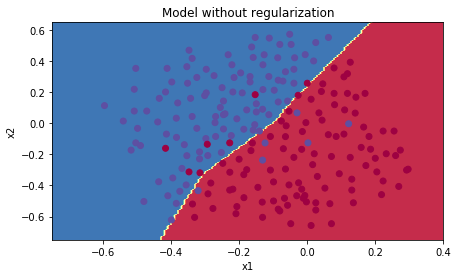

Accuracy: 0.938388625592
Accuracy: 0.93
accurary for training: 86.01630915244984
accurary for test: 87.96895587909523


In [25]:
from reg_utils import load_2D_dataset, plot_decision_boundary 
import matplotlib.pyplot as plt
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = linear_forward_propagation(parameters, X, relu)
    predictions = (a3>0.5)
    return predictions


np.random.seed(3)
train_X, train_Y, test_X, test_Y = load_2D_dataset()
layer_dims = [train_X.shape[0],  20, 3, 1]

parameters, cost = nn_model(train_X, train_Y, layer_dims, lambd=0.7, learning_rate=0.3, loop=30000, print_th_iter=10000)

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

predict(train_X, train_Y, parameters, relu)
predict(test_X, test_Y, parameters, relu)
print("accurary for training: {}".format(accuracy(parameters, train_X, train_Y)))
print("accurary for test: {}".format(accuracy(parameters, test_X, test_Y)))


In [4]:
a = np.random.randn(1, 5)
print (a.shape, a[0, :].shape)

(1, 5) (5,)
